In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm


In [4]:
df=pd.read_csv("/content/air_pollution.csv",parse_dates=['date'])
df.set_index('date', inplace=True)

In [53]:
df.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [6]:
df.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pollution_today      1825 non-null   float64
 1   dew                  1825 non-null   float64
 2   temp                 1825 non-null   float64
 3   press                1825 non-null   float64
 4   wnd_spd              1825 non-null   float64
 5   snow                 1825 non-null   float64
 6   rain                 1825 non-null   float64
 7   pollution_yesterday  1825 non-null   float64
dtypes: float64(8)
memory usage: 128.3 KB


Plot for each feature over the time

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


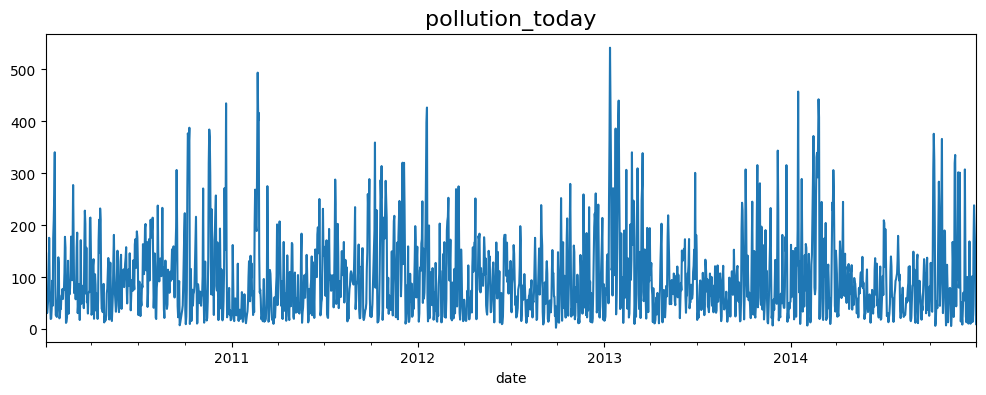

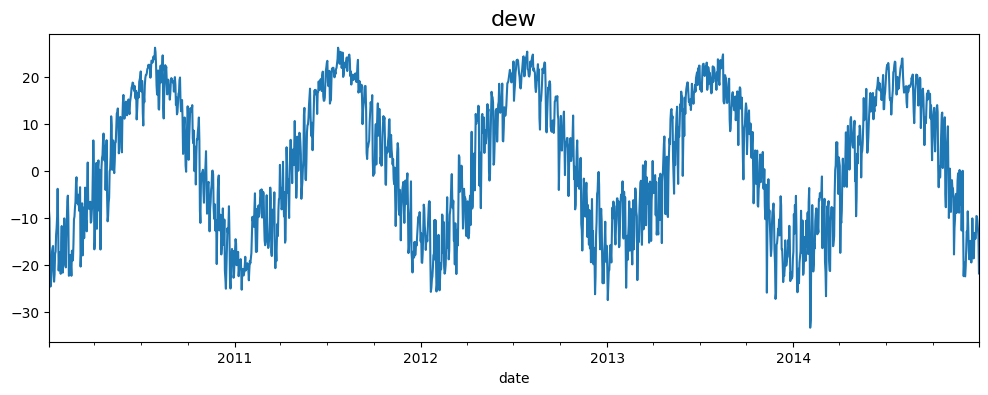

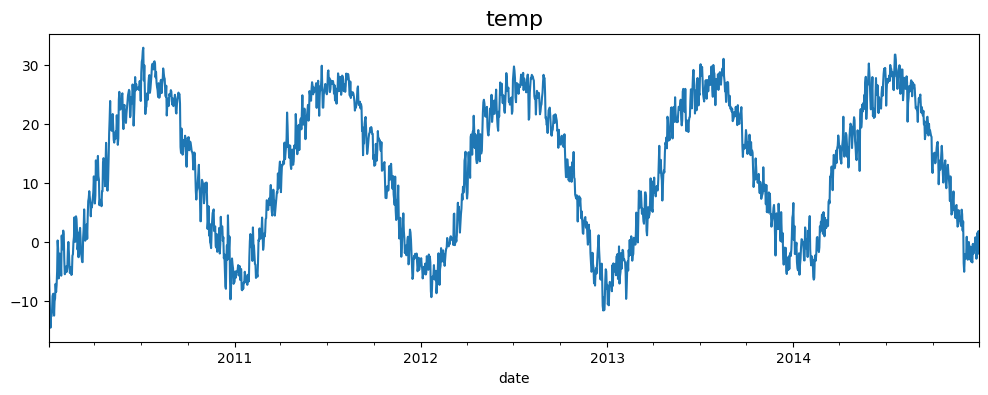

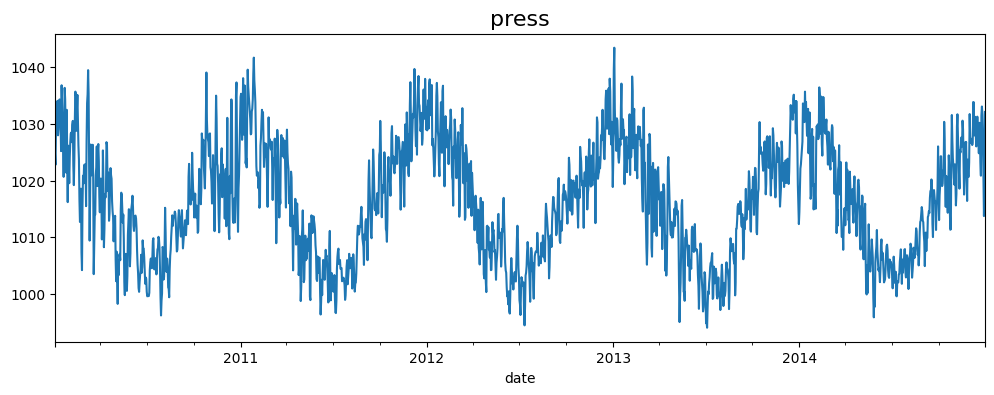

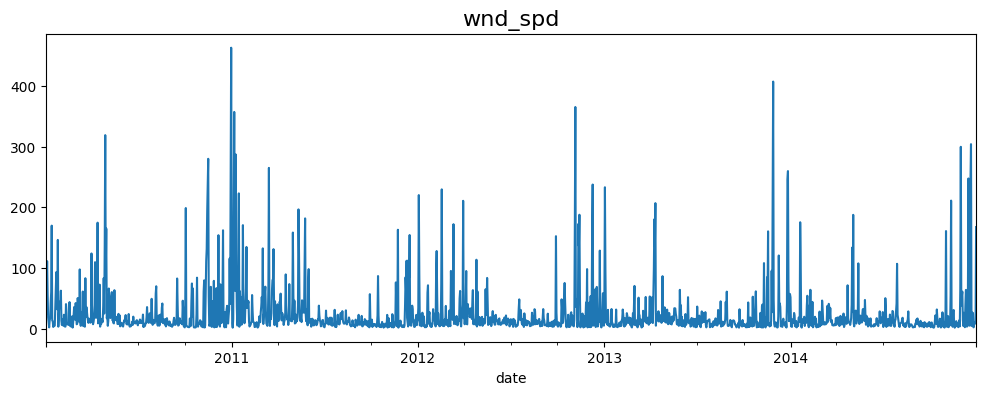

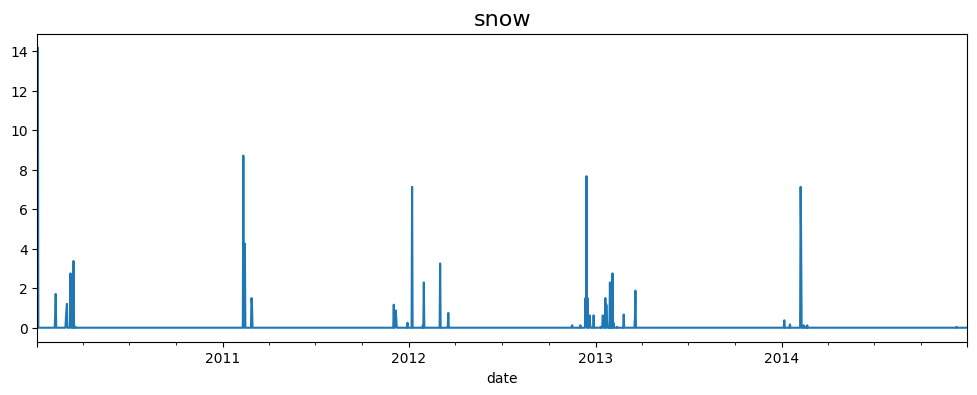

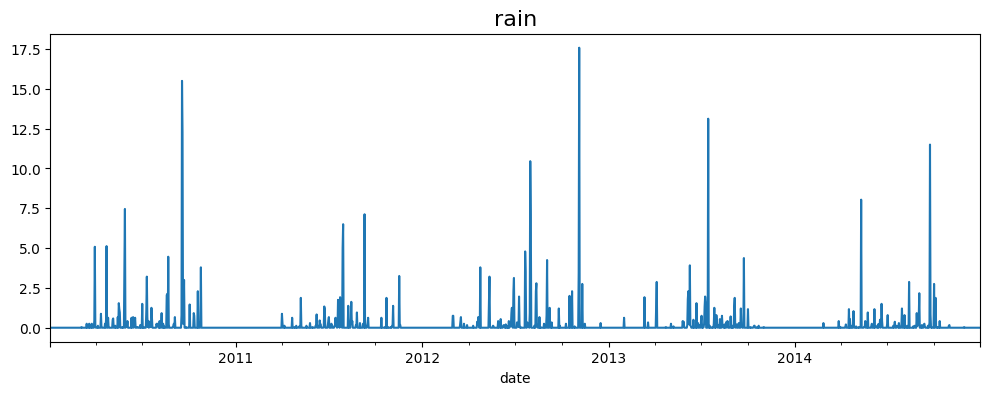

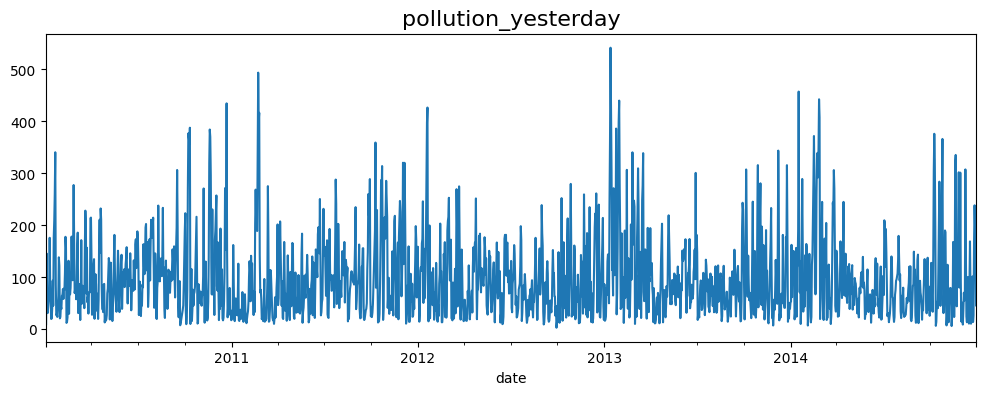

In [8]:
for i in df:
  plt.figure(figsize=(12,4))
  plt.title(i,fontsize=16)
  print(df[i].plot())

pollution_today is decomposed into Trend,Seasoniality,Residue

<Figure size 2000x2000 with 0 Axes>

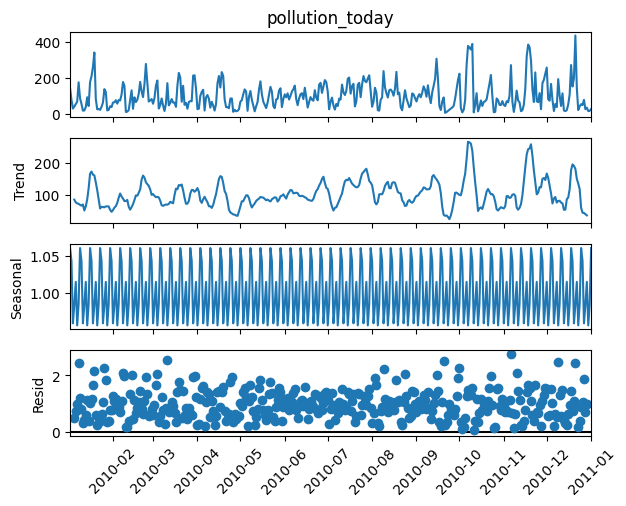

In [9]:


plt.figure(figsize=(20,20), dpi=100)

series = df['pollution_today'][:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

# Set x-axis ticks and labels to match the dates
plt.xticks( rotation=45)

# Display the plot
plt.show()


Check for the trend

Text(0.5, 1.0, 'Moving average 12 steps')

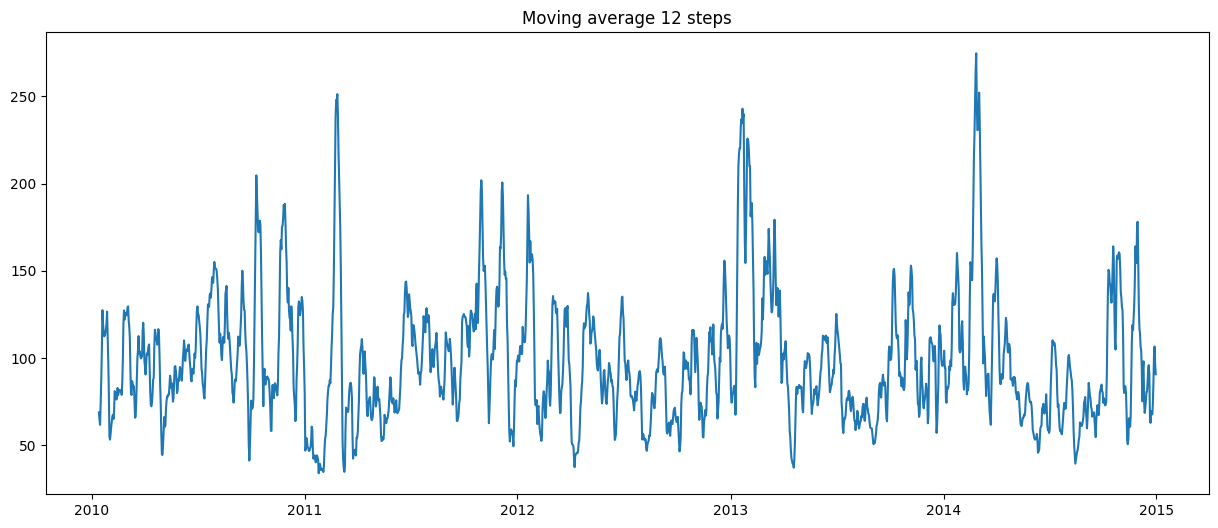

In [10]:
mm = df.pollution_today.rolling(12).mean()
plt.figure(figsize=(15,6))
plt.plot(mm)
plt.title("Moving average 12 steps")

We can see our series does not have a strong trend

Check for Seasonality by visual method.

<Figure size 2000x2000 with 0 Axes>

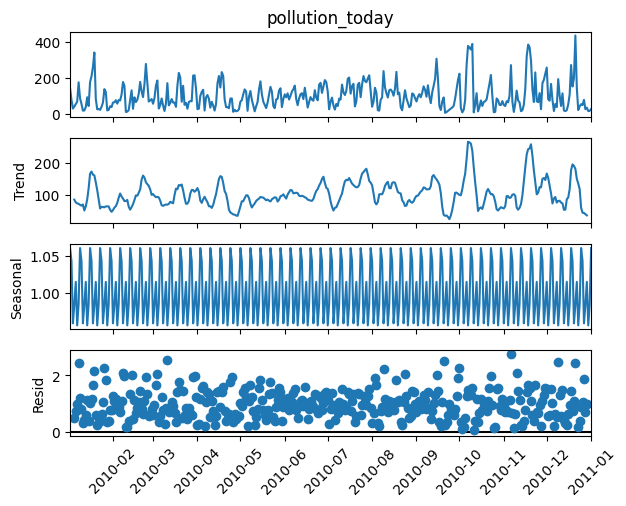

In [11]:


plt.figure(figsize=(20,20), dpi=100)

series = df['pollution_today'][:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

# Set x-axis ticks and labels to match the dates
plt.xticks( rotation=45)

# Display the plot
plt.show()


Check for stationarity by ADF test

here we can see a clear weekly trend, 4 spikes every month (weerkly).

In [12]:
v=df.pollution_today.values
res=adfuller(v)
print("ADfuller statistics:- {}".format(res[0]))
print("p value:- {}".format(res[1]))

ADfuller statistics:- -10.116719049378304
p value:- 9.680895053879114e-18


from this test we can see that our data is stationay (pvalue<.05)

### Autocorrelation and Partial autocorrelation plots

<Figure size 1200x500 with 0 Axes>

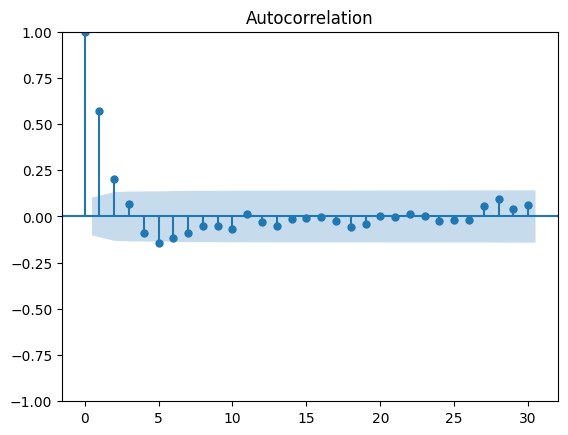

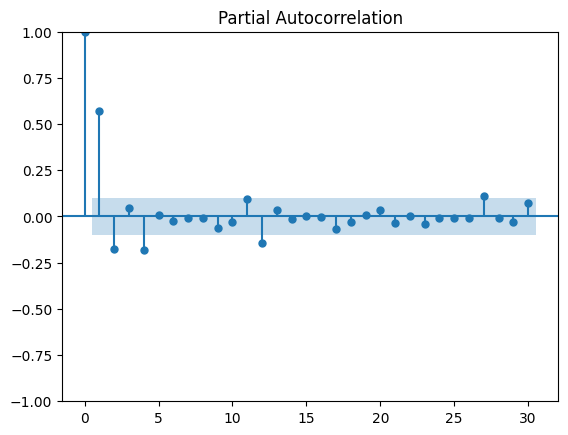

In [13]:
plt.figure(figsize=(12,5))
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

Train-test split

In [14]:
df1=df.drop(columns=['pollution_today','dew','temp',	'press'	,'wnd_spd','snow','rain'])
df1

,pollution_yesterday
date,
2010-01-02,10.041667
2010-01-03,145.958333
2010-01-04,78.833333
2010-01-05,31.333333
2010-01-06,42.458333
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


In [15]:
train=df1.iloc[0:int(len(df1)*.8),:]
test=df1.iloc[int(len(df1)*.8) : int(len(df1)),:]


In [16]:
train

,pollution_yesterday
date,
2010-01-02,10.041667
2010-01-03,145.958333
2010-01-04,78.833333
2010-01-05,31.333333
2010-01-06,42.458333
...,...
2013-12-27,14.625000
2013-12-28,31.916667
2013-12-29,21.125000


In [17]:
test

,pollution_yesterday
date,
2014-01-01,51.833333
2014-01-02,53.416667
2014-01-03,162.625000
2014-01-04,61.916667
2014-01-05,150.416667
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


##univariate Modeling

1) Simple Exponetial Smoothing

In [18]:
y_hat = []  # Initialize an empty list to store predictions

for i in range(len(test)):
    temp_train = df[:len(train) + i]

    # Set the frequency of the index explicitly
    temp_train.index.freq = 'D'

    model1 = SimpleExpSmoothing(temp_train.pollution_yesterday)
    m_fit = model1.fit()

    # Predict using the fitted model
    pred = m_fit.predict(start=len(temp_train), end=len(temp_train))

    y_hat = y_hat + [pred]

# Concatenate the list of predictions into a pandas Series
y_hat = pd.concat(y_hat)


In [19]:
y_hat

2014-01-01     40.943106
2014-01-02     49.289785
2014-01-03     52.452895
2014-01-04    136.926169
2014-01-05     79.569796
                 ...    
2014-12-27     28.090122
2014-12-28    139.368705
2014-12-29    217.656732
2014-12-30    201.686657
2014-12-31    168.126473
Freq: D, Length: 365, dtype: float64

In [20]:
test

,pollution_yesterday
date,
2014-01-01,51.833333
2014-01-02,53.416667
2014-01-03,162.625000
2014-01-04,61.916667
2014-01-05,150.416667
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


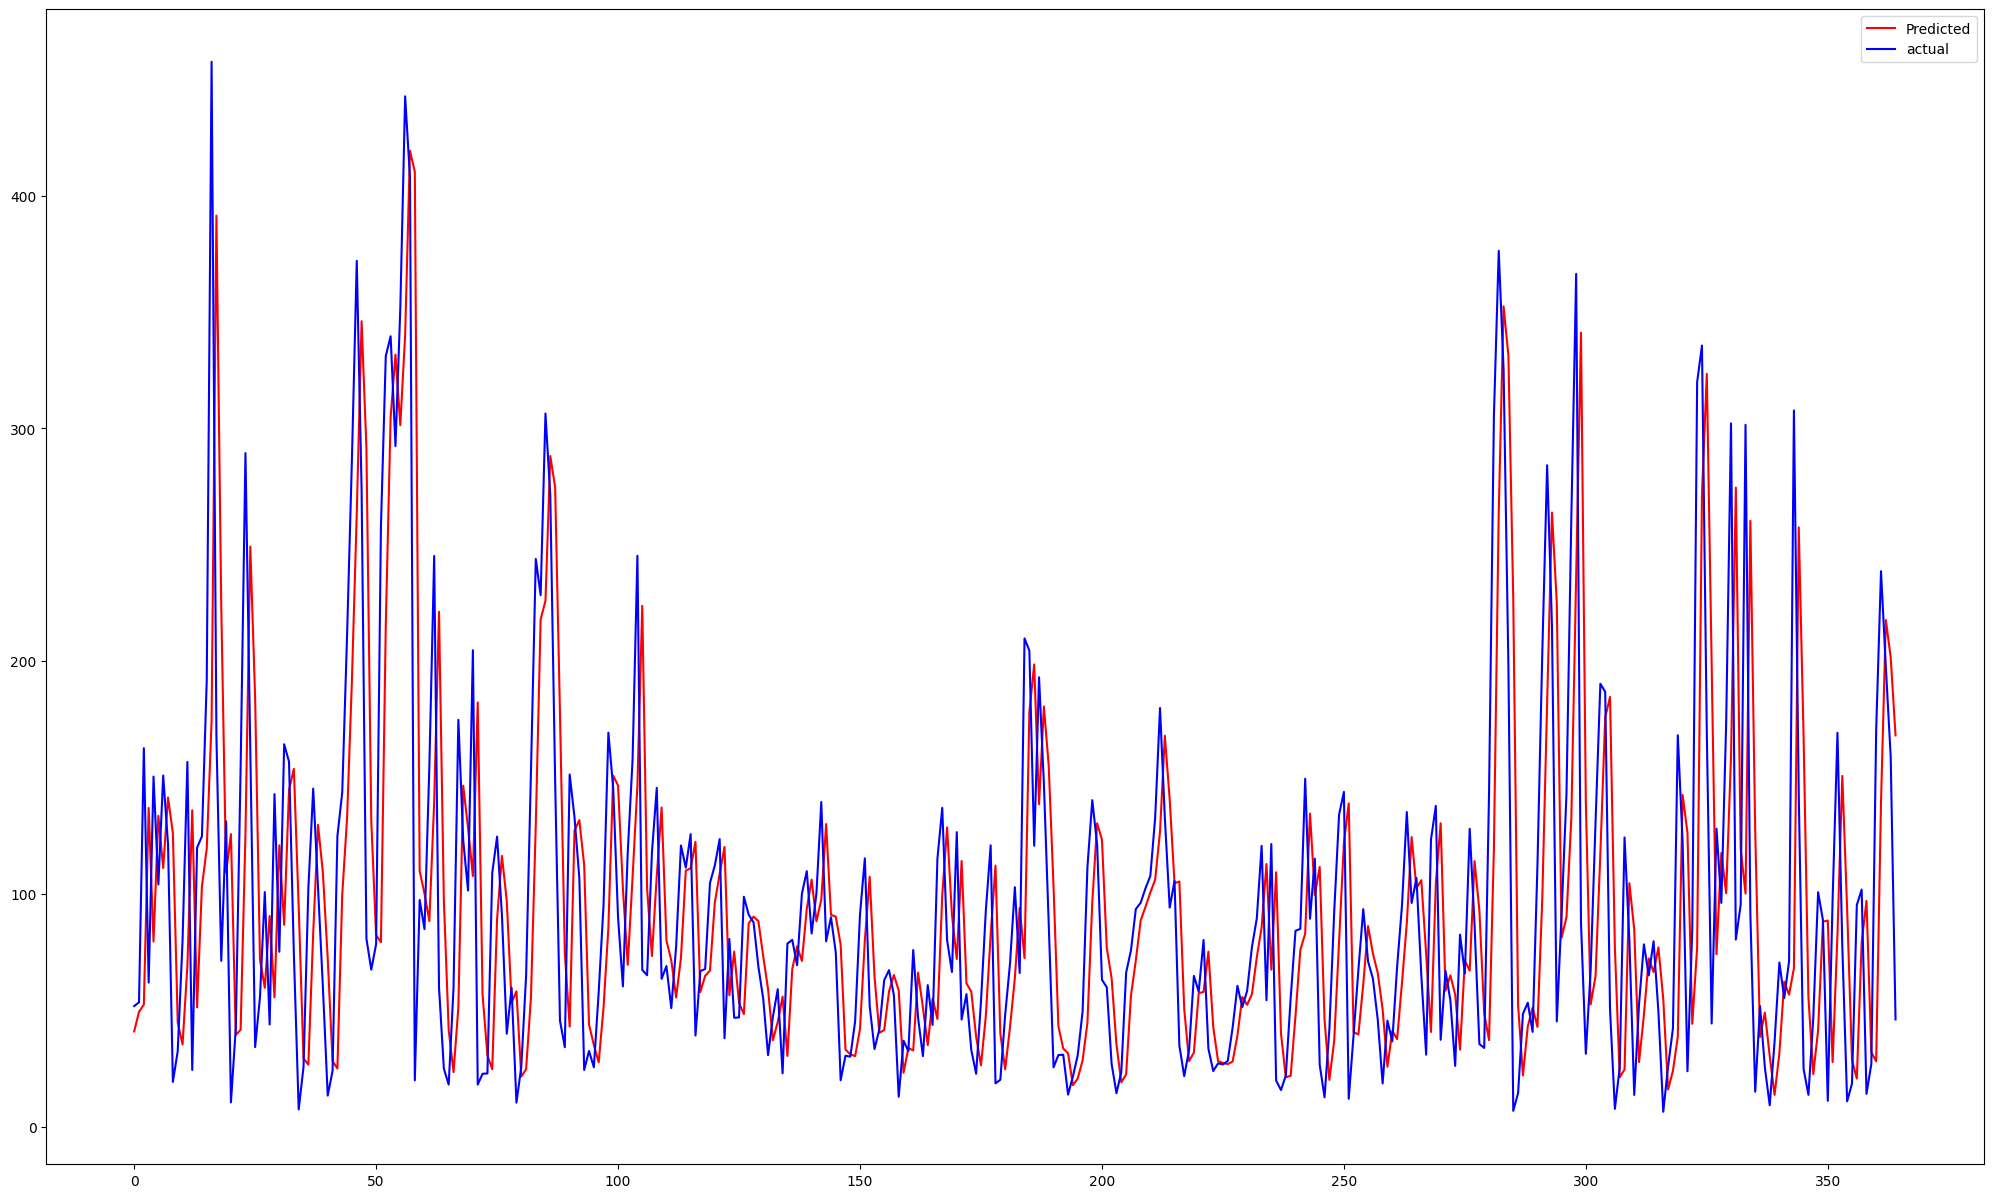

In [21]:
plt.figure(figsize=(25,15))
plt.plot(y_hat.values,color='r',label='Predicted')
plt.plot(test.values,color='b',label='actual' )
plt.legend()

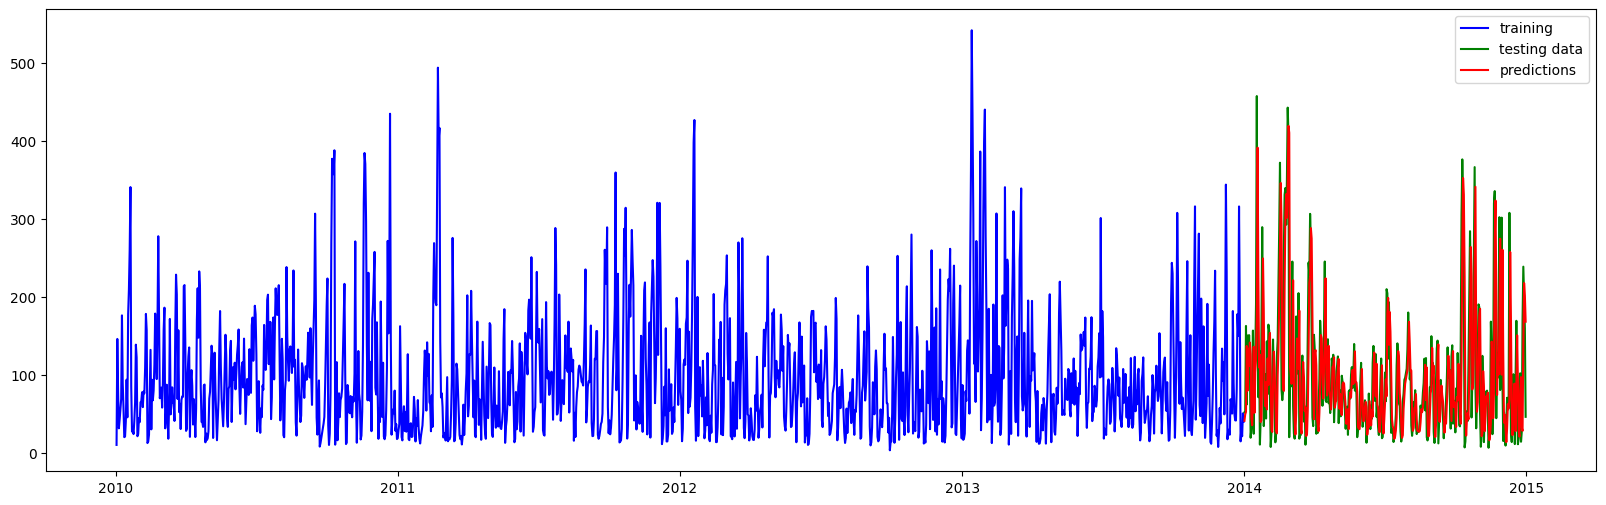

In [22]:
plt.figure(figsize=(20,6))
plt.plot(train,color='b',label='training')

plt.plot(test,color='g',label='testing data')
plt.plot(y_hat,color='r',label='predictions')
plt.legend()

In [23]:
import math
rmse=math.sqrt(mean_squared_error(y_hat,test))
rmse

74.5077739153655

2) Auto-regression model (AR Model)

In [24]:
y_hat1 = []  # Initialize an empty list to store predictions

for i in range(len(test)):
    temp_train = df[:len(train) + i]

    # Set the frequency of the index explicitly
    temp_train.index.freq = 'D'

    model2 = AutoReg(temp_train.pollution_yesterday,lags=5)
    m_fit2 = model2.fit()

    # Predict using the fitted model
    pred = m_fit2.predict(start=len(temp_train), end=len(temp_train),dynamic=False)

    y_hat1 = y_hat1 + [pred]

# Concatenate the list of predictions into a pandas Series
y_hat1 = pd.concat(y_hat1)



In [25]:
y_hat1

2014-01-01     65.839625
2014-01-02     77.691394
2014-01-03     74.710127
2014-01-04    147.618492
2014-01-05     62.289960
                 ...    
2014-12-27     63.308592
2014-12-28    154.912748
2014-12-29    178.812494
2014-12-30    141.580804
2014-12-31    121.162031
Freq: D, Length: 365, dtype: float64

In [26]:
test

,pollution_yesterday
date,
2014-01-01,51.833333
2014-01-02,53.416667
2014-01-03,162.625000
2014-01-04,61.916667
2014-01-05,150.416667
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


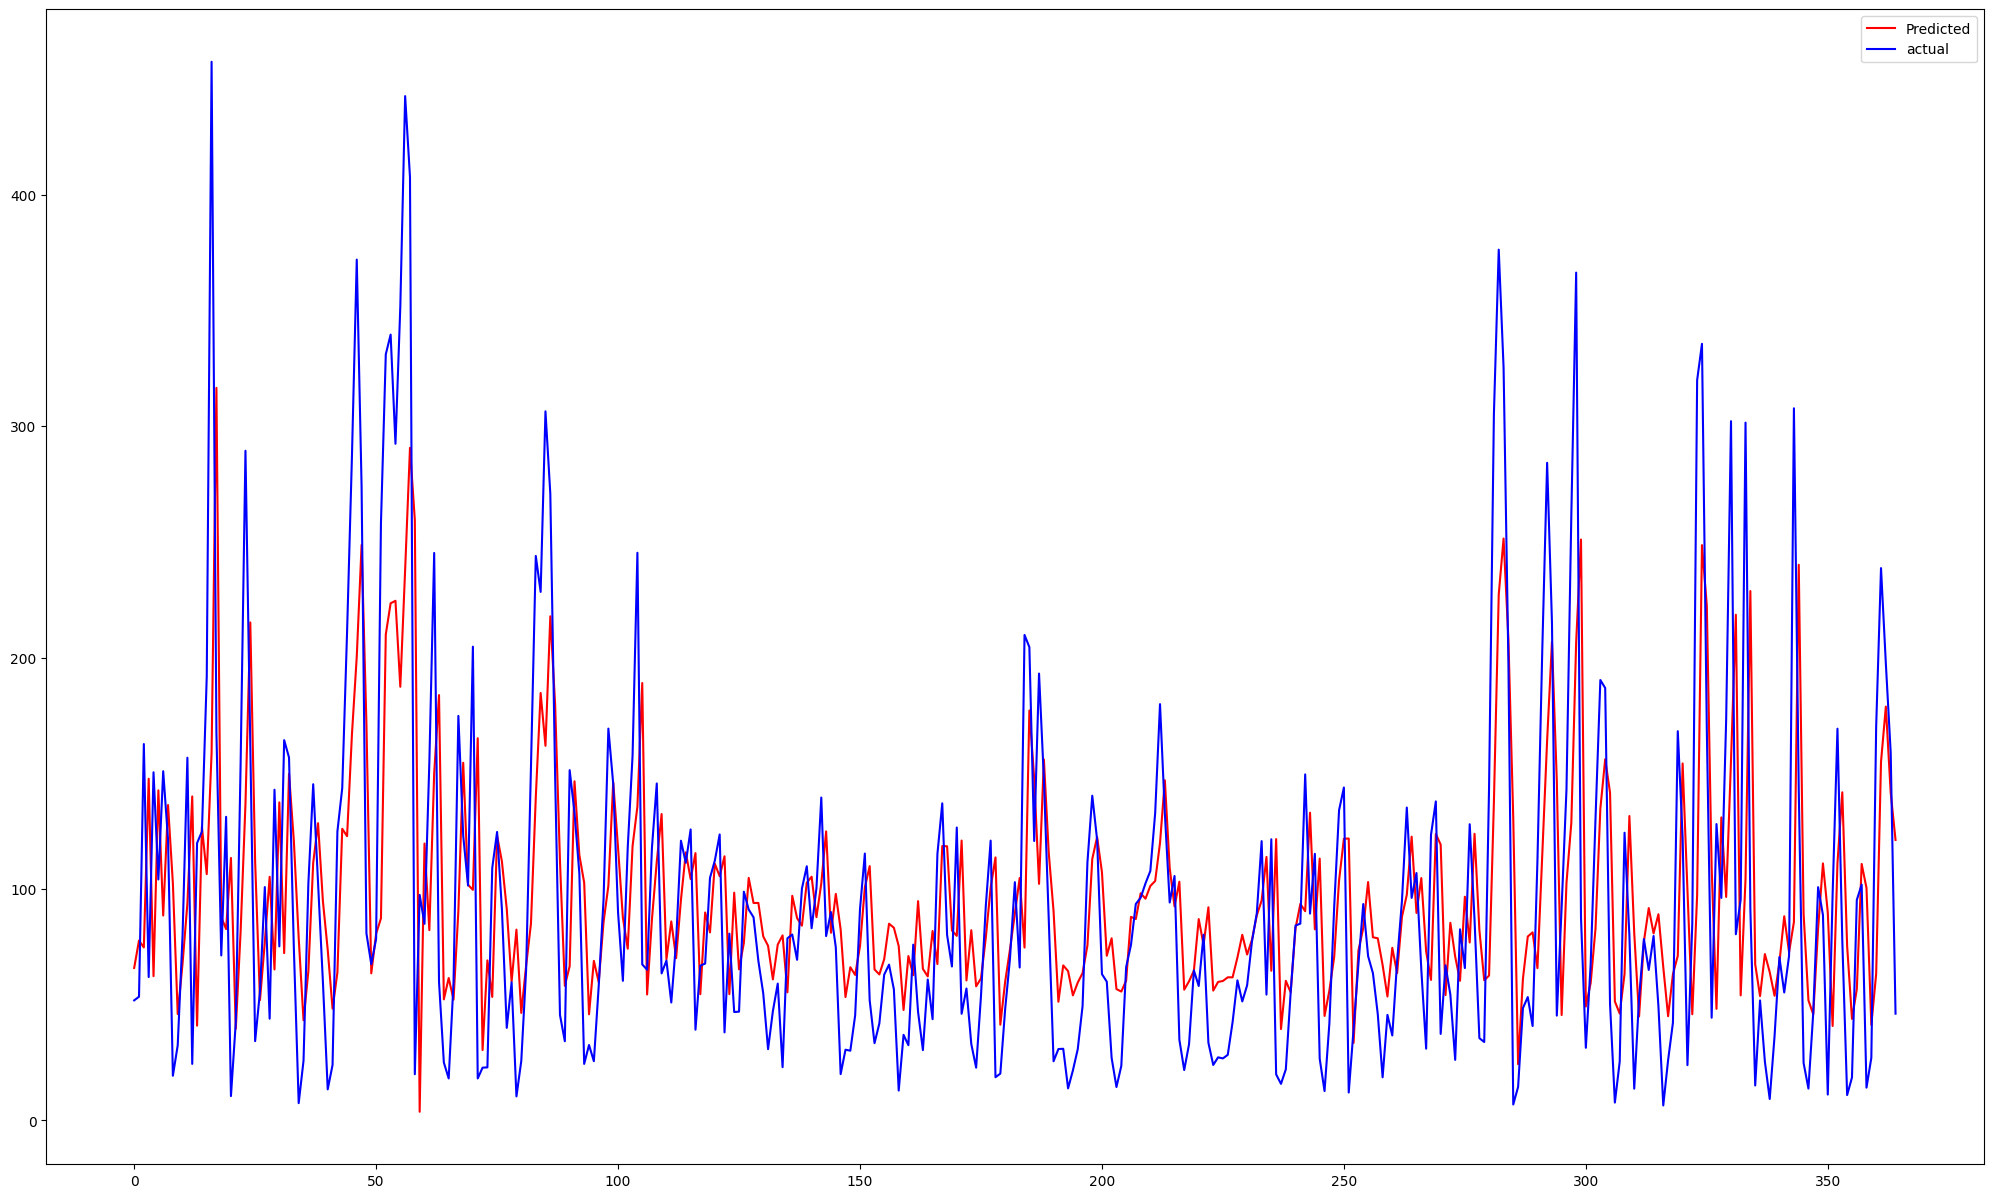

In [27]:
plt.figure(figsize=(25,15))
plt.plot(y_hat1.values,color='r',label='Predicted')
plt.plot(test.values,color='b',label='actual' )
plt.legend()

Root mean squared value for AR model is :- 64.65322387140749


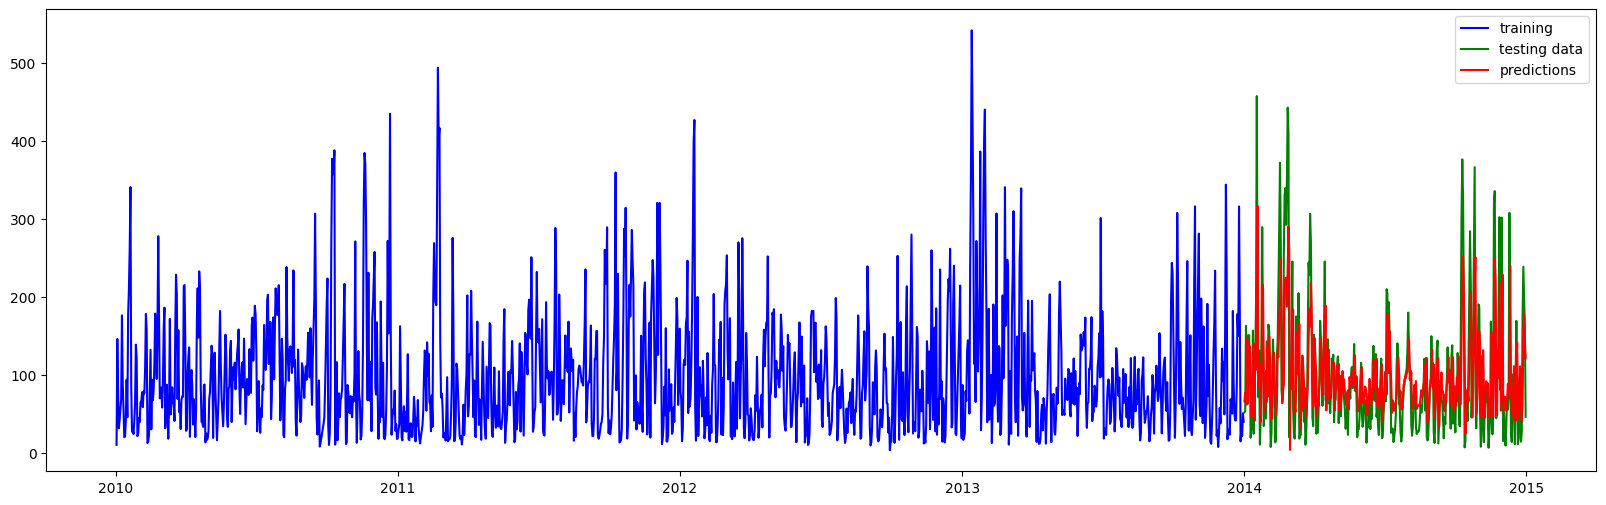

In [28]:
plt.figure(figsize=(20,6))
plt.plot(train,color='b',label='training')

plt.plot(test,color='g',label='testing data')
plt.plot(y_hat1,color='r',label='predictions')
plt.legend()
import math
rmse1=math.sqrt(mean_squared_error(y_hat1,test))
print("Root mean squared value for AR model is :-" , rmse1)

3) Moving Average Model (MA Model) using ARIMA function

In [29]:
y_hat2 = []  # Initialize an empty list to store predictions

for i in range(len(test)):
    temp_train = df[:len(train) + i]

    # Set the frequency of the index explicitly
    temp_train.index.freq = 'D'

    model2 = ARIMA(temp_train.pollution_yesterday,order=(0,0,2))
    m_fit2 = model2.fit()

    # Predict using the fitted model
    pred = m_fit2.predict(start=len(temp_train), end=len(temp_train))

    y_hat2 = y_hat2 + [pred]

# Concatenate the list of predictions into a pandas Series
y_hat2 = pd.concat(y_hat2)


In [30]:
y_hat2

2014-01-01     70.510523
2014-01-02     78.525776
2014-01-03     78.637150
2014-01-04    146.938609
2014-01-05     60.415188
                 ...    
2014-12-27     72.307342
2014-12-28    158.731584
2014-12-29    168.674807
2014-12-30    132.077243
2014-12-31    121.226833
Freq: D, Length: 365, dtype: float64

In [31]:
test

,pollution_yesterday
date,
2014-01-01,51.833333
2014-01-02,53.416667
2014-01-03,162.625000
2014-01-04,61.916667
2014-01-05,150.416667
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


Root mean squared value for MR model is :- 64.98289670093422


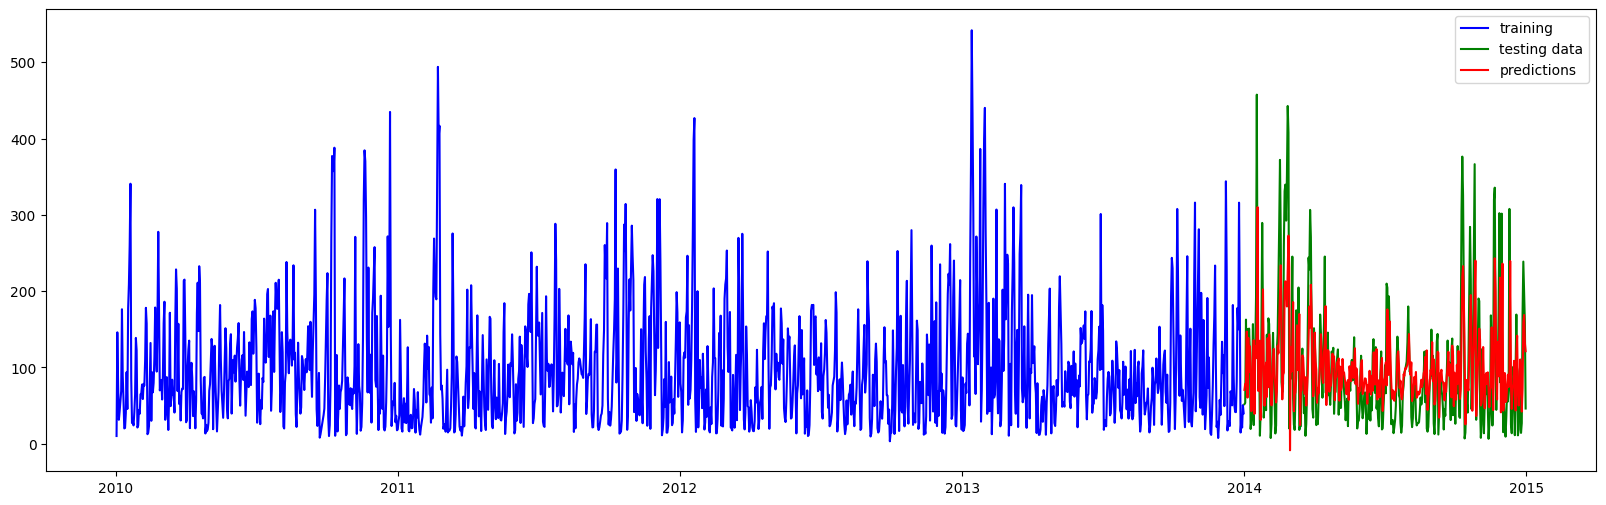

In [52]:
plt.figure(figsize=(20,6))
plt.plot(train,color='b',label='training')

plt.plot(test,color='g',label='testing data')
plt.plot(y_hat2,color='r',label='predictions')
plt.legend()
import math
rmse2=math.sqrt(mean_squared_error(y_hat2,test))
print("Root mean squared value for MR model is :-" , rmse2)

3) ARIMA Model

In [38]:
# building the model

autoModel = pm.auto_arima(train.pollution_yesterday, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(train.pollution_yesterday)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18220.892, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16453.663, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17181.496, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16454.989, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16454.401, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16448.087, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16259.138, Time=0.79 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16860.010, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16210.600, Time=0.94 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16702.527, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.79 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [40]:
Order=autoModel.order
y_hat3 = []  # Initialize an empty list to store predictions

for i in range(len(test)):
    temp_train = df[:len(train) + i]

    # Set the frequency of the index explicitly
    temp_train.index.freq = 'D'

    model3 = ARIMA(temp_train.pollution_yesterday,order=Order)
    m_fit3 = model3.fit()

    # Predict using the fitted model
    pred = m_fit3.predict(start=len(temp_train), end=len(temp_train))

    y_hat3 = y_hat3 + [pred]

# Concatenate the list of predictions into a pandas Series
y_hat3 = pd.concat(y_hat3)


In [41]:
y_hat3

2014-01-01     65.102215
2014-01-02     78.410675
2014-01-03     74.702830
2014-01-04    148.127317
2014-01-05     61.839466
                 ...    
2014-12-27     64.935369
2014-12-28    155.970638
2014-12-29    178.745454
2014-12-30    142.061014
2014-12-31    122.405596
Freq: D, Length: 365, dtype: float64

In [42]:
test

,pollution_yesterday
date,
2014-01-01,51.833333
2014-01-02,53.416667
2014-01-03,162.625000
2014-01-04,61.916667
2014-01-05,150.416667
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


Root mean squared value for ARIMA model is :- 64.60564620257631


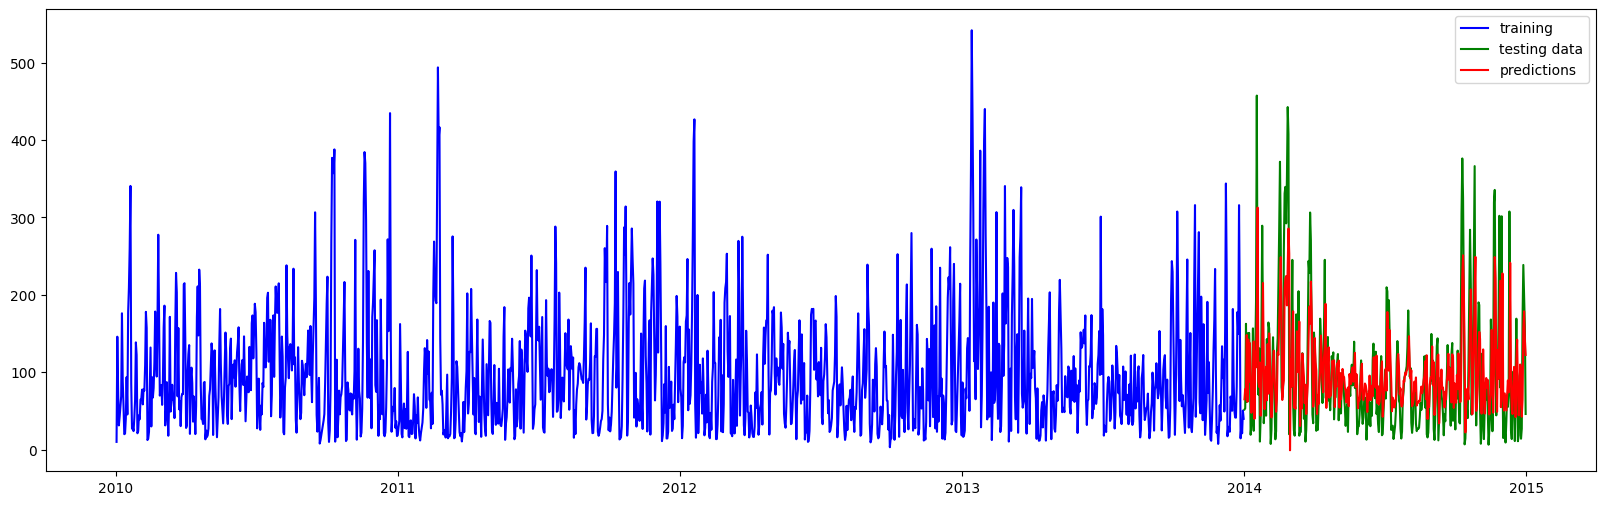

In [51]:
plt.figure(figsize=(20,6))
plt.plot(train,color='b',label='training')

plt.plot(test,color='g',label='testing data')
plt.plot(y_hat3,color='r',label='predictions')
plt.legend()
import math
rmse3=math.sqrt(mean_squared_error(y_hat3,test))
print("Root mean squared value for ARIMA model is :-" , rmse3)

4) SARIMA Model

In [44]:

autoModel = pm.auto_arima(train.pollution_yesterday, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=True,m=6,stepwise=True)
autoModel.fit(train.pollution_yesterday)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=16192.666, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16778.550, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=16222.338, Time=1.01 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=16258.689, Time=1.81 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=18220.892, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=16193.928, Time=1.45 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=16193.931, Time=0.81 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=16197.404, Time=2.07 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=16197.386, Time=2.22 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=16192.005, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=16191.407, Time=0.25 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=16191.944, Time=1.49 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=16191.939, Time=2.64 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=16193.832, Time=1.87 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [46]:
Order=autoModel.order
seasonalorder=autoModel.seasonal_order
y_hat4 = []  # Initialize an empty list to store predictions

for i in range(len(test)):
    temp_train = df[:len(train) + i]

    # Set the frequency of the index explicitly
    temp_train.index.freq = 'D'

    model4 = SARIMAX(temp_train.pollution_yesterday,order=Order,seasonal_order=seasonalorder)
    m_fit4 = model4.fit()

    # Predict using the fitted model
    pred = m_fit4.predict(start=len(temp_train), end=len(temp_train))

    y_hat4 = y_hat4 + [pred]

# Concatenate the list of predictions into a pandas Series
y_hat4 = pd.concat(y_hat4)


In [47]:
y_hat4

2014-01-01     34.016265
2014-01-02     43.296820
2014-01-03     45.021217
2014-01-04    132.872802
2014-01-05     56.386344
                 ...    
2014-12-27     22.460053
2014-12-28    140.540355
2014-12-29    199.243522
2014-12-30    166.028253
2014-12-31    133.816699
Freq: D, Length: 365, dtype: float64

In [48]:
test

,pollution_yesterday
date,
2014-01-01,51.833333
2014-01-02,53.416667
2014-01-03,162.625000
2014-01-04,61.916667
2014-01-05,150.416667
...,...
2014-12-27,170.250000
2014-12-28,238.666667
2014-12-29,197.375000


Root mean squared value for AR model is :- 71.3845102644504


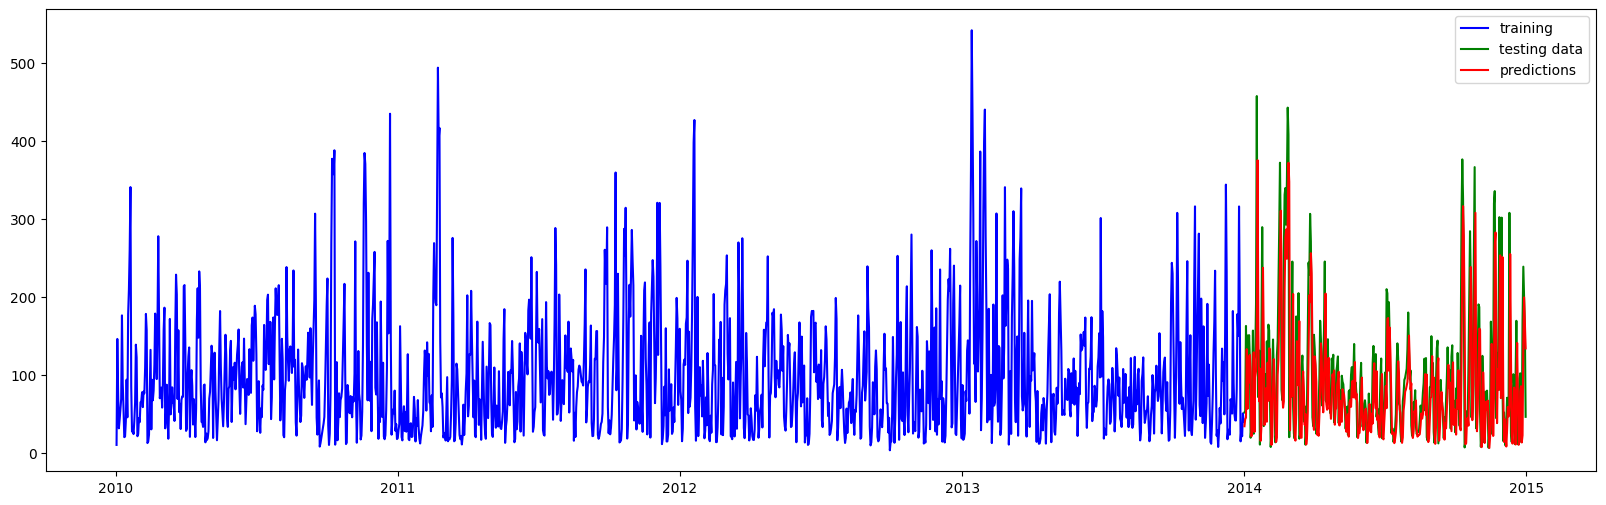

In [50]:
plt.figure(figsize=(20,6))
plt.plot(train,color='b',label='training')

plt.plot(test,color='g',label='testing data')
plt.plot(y_hat4,color='r',label='predictions')
plt.legend()
import math
rmse4=math.sqrt(mean_squared_error(y_hat4,test))
print("Root mean squared value for SARMAX model is :-" , rmse4)

Multivariate Time series by LSTM

Epoch 1/20
46/46 [==============================] - 5s 4ms/step - loss: 0.0525
Epoch 2/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 3/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0078
Epoch 4/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 5/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0073
Epoch 6/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0072
Epoch 7/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 8/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 9/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 10/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 11/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 12/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 13/20
46/46 [==============================

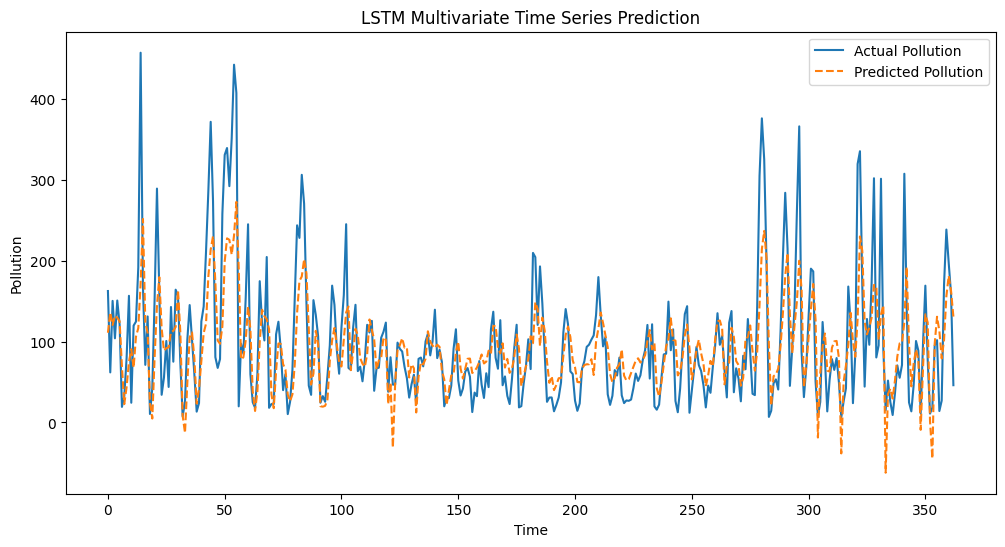

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Select features for training
features = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'pollution_yesterday']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Create sequences for LSTM training
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Set the sequence length
sequence_length = 10  # You can adjust this based on your preference

# Create sequences and targets
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(features), activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate Mean Squared Error (MSE)


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 6], label='Actual Pollution')
plt.plot(predictions_inv[:, 6], label='Predicted Pollution', linestyle='dashed')
plt.title('LSTM Multivariate Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.legend()
plt.show()


In [69]:
mse = math.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f' Root Mean Squared Error (MSE): {mse}')

 Root Mean Squared Error (MSE): 24.918220697567378
